# DLCV Assignment 1

**Due Date: 22/02/2024 11:59PM IST**

**Name: Sai Teja Kuchi**

**Sr. No.: 21317**


In this assignment, we will cover the following topics:

1) Training a simple Linear Model 

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used. 

# Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify an input $X_i$ of size $n$ into one of $m$ classes. For this, you need to consider the following:

1)  **Weight Matrix** $W_{n\times m}$: The Weights are multipled with the input $X_i$ (vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2)  **The Loss function**:   
  * The Cross Entropy Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $y_i$-th element of the output of $W^T  X_i$

3) **A Regularization term**: In addition to the loss, you need a Regularization term to lead to a more distributed (in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, with $L_2$ regularization, the loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2  
$$

Thus the total loss has the form:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

4) **An Optimization Procedure**: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:
$$
W_{t+1} = W_{t} - \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, with "mini-batch" gradient descent, instead of finding loss over the whole dataset, we use a small sample $B$ of the training data to make each learning step. Hence,
$$
W_{t+1} = W_{t} - \alpha \frac{\partial \sum_{i \in B}{L_{x_i}}}{\partial W},
$$
where $|B|$ is the batch size.

# Question 1

Train a **Single-Layer Classifier** for the MNIST dataset. 
* Use Softmax-Loss.
* Maintain a train-validation split of the original training set for finding the right value of $\lambda$ for the regularization, and to check for over-fitting.
* Finally, evaluate the classification performance on the test-set.


In [1]:
import os
import struct

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(41)

In [2]:
# Load The Mnist data:
# Download data from http://yann.lecun.com/exdb/mnist/
# load the data.
def load_mnist_data(path_to_data, dataset_type):
    path_to_images, path_to_labels = None, None

    if dataset_type == 'train':
        path_to_images, path_to_labels = os.path.join(
            path_to_data, 'train-images.idx3-ubyte'), os.path.join(path_to_data, 'train-labels.idx1-ubyte')
    else:
        path_to_images, path_to_labels = os.path.join(
            path_to_data, 't10k-images.idx3-ubyte'), os.path.join(path_to_data, 't10k-labels.idx1-ubyte')

    image_data, label_data = None, None
    with open(path_to_labels, 'rb') as labels_file:
        magic, size = struct.unpack(">II", labels_file.read(8))
        if magic != 2049:
            raise ValueError(
                'Magic number mismatch, expected 2049, got {}'.format(magic))
        label_data = np.fromfile(labels_file, dtype=np.uint8)

    with open(path_to_images, 'rb') as images_file:
        magic, size, rows, cols = struct.unpack(">IIII", images_file.read(16))
        if magic != 2051:
            raise ValueError(
                'Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = np.fromfile(
            images_file, dtype=np.uint8)
        image_data = image_data.reshape(size, rows * cols)

    return image_data, label_data

In [3]:
# maintain a train-val split
def split_data(image_data, label_data, validation_percent=0.2):
    total_image_count = image_data.shape[0]
    validation_count = int(validation_percent * total_image_count)
    index_data = np.arange(total_image_count)
    np.random.shuffle(index_data)
    validation_idxs, train_idxs = index_data[:
                                             validation_count], index_data[validation_count:]
    image_data_part2, label_data_part2 = image_data[validation_idxs], label_data[validation_idxs]
    image_data_part1, label_data_part1 = image_data[train_idxs], label_data[train_idxs]
    return image_data_part1, label_data_part1, image_data_part2, label_data_part2

In [4]:

# Now, write a generator that yields (random) mini-batches of the input data
# Do not use same set of mini-batches for different epochs
def get_minibatch(training_x, training_y, batch_size=32):
    # Read about Python generators if required.

    # WRITE CODE HERE
    train_sample_count = training_x.shape[0]
    index_data = np.arange(train_sample_count)
    np.random.shuffle(index_data)
    for index_value in range(0, train_sample_count, batch_size):
        index_values = index_data[index_value:index_value+batch_size]
        mini_x, mini_y = training_x[index_values], training_y[index_values]
        yield mini_x, mini_y

In [5]:
# Define the class for a Single Layer Classifier
class Single_layer_classifier():

    def __init__(self, input_size, output_size, lambda_value = 1e-3):

        # WRITE CODE HERE

        # Give the instance a weight matrix, initialized randomly
        # One possible strategy for a good initialization is Normal (0, σ) where σ = 1e-3.
        # Try experimenting with different values of σ.

        # TODO :- vary below and see results.
        self.std = 1e-3

        self.weights = np.random.normal(0, self.std, (input_size, output_size))
        self.bias = np.zeros((1, output_size))
        self.lambda_value = lambda_value

    # Define the forward function
    def forward(self, input_x):

        # get the scores

        # WRITE CODE HERE
        scores = np.matmul(input_x, self.weights) + self.bias
        return scores

    # Similarly a backward function
    # we define 2 backward functions (as Loss = L_data + L_reg, grad(Loss) = grad(L1) + grad(L2))

    def backward_Ldata(self, grad_from_loss, x_data):

        # this function returns a matrix of the same size as the weights,
        # where each element is the partial derivative of the loss w.r.t. the corresponding element of W

        # WRITE CODE HERE

        grad_matrix = np.dot(x_data.T, grad_from_loss)        
        grad_bias = np.sum(grad_from_loss, axis=0)
        return grad_matrix, grad_bias

    def backward_Lreg(self):

        # this function returns a matrix of the same size as the weights,
        # where each element is the partial derivative of the regularization-term
        # w.r.t. the corresponding element of W

        # WRITE CODE HERE
        grad_matrix = 2 * self.weights * self.lambda_value
        return grad_matrix

In [6]:
# Implement the Softmax loss function
def loss_function(input_y, scores, lambda_value, weights):

    num_examples = scores.shape[0]

    scores = scores - np.max(scores, axis=1, keepdims=True) # numerical stability.
    probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
    correct_class_probs = probs[np.arange(num_examples), input_y]

    data_loss = -np.sum(np.log(correct_class_probs)) / num_examples
    reg_loss = 0.5 * lambda_value * \
        sum(np.sum(weighti ** 2) for weighti in weights)
    loss = data_loss + reg_loss

    grad_logits = probs.copy()
    grad_logits[np.arange(num_examples), input_y] -= 1
    grad_logits /= num_examples

    return loss, grad_logits

### Create utility functions for calculating training and validation accuracy

In [7]:
# WRITE CODE HERE
def get_accuracy(predictions, actual):
    return np.mean(predictions == actual)

In [8]:
X_train, y_train = load_mnist_data('./data', 'train')
X_test, y_test = load_mnist_data('./data', 'test')

X_train = X_train / 255
X_test = X_test / 255

num_of_classes = len(set(y_train))
X_train, y_train, X_valid, y_valid = split_data(X_train, y_train)

In [9]:
def train_slc_model(X_train, y_train, X_valid, y_valid, num_of_classes, alpha=1e-4, lambda_value=1e-3, epochs=50, batch_size=32, print_epoch_data=True, early_stopping_diff=1e-7):

    # Make an instance of Single_layer_classifier
    model = Single_layer_classifier(X_train.shape[1], num_of_classes, lambda_value)

    train_loss_data, train_accuracy_data, validation_loss_data, validation_accuracy_data = [], [], [], []
    early_stop_chances = 3
    # Train for t epochs:
    for epoch in range(epochs):

        # Train on the train-set obtained from train-validation split
        # Use the mini-batch generator to get each mini-batch
        minibatch = get_minibatch(X_train, y_train, batch_size)
        batch_loss_data = []

        # Write code here for each iteration of training
        for iter_num, (input_x, input_y) in enumerate(minibatch):

            # Forward pass
            scores = model.forward(input_x)
            loss_value, grad_from_loss = loss_function(
                input_y, scores, lambda_value, [model.weights])
            batch_loss_data.append(loss_value)

            # Backward pass
            grad_w, grad_b = model.backward_Ldata(grad_from_loss, input_x)
            grad_w += model.backward_Lreg()

            # Update weights
            model.weights = model.weights - alpha * grad_w
            model.bias = model.bias - alpha * grad_b

        # Log the training loss value and training accuracy
        train_loss = np.mean(batch_loss_data)
        y_train_pred = np.argmax(model.forward(X_train), axis=1)
        train_accuracy = get_accuracy(y_train_pred, y_train)
        train_accuracy_data.append(train_accuracy)
        train_loss_data.append(train_loss)

        # Logging validation loss value and accuracies to check for overfitting cases.
        validation_scores = model.forward(X_valid)
        validation_loss, _ = loss_function(
            y_valid, validation_scores, lambda_value, [model.weights])

        y_valid_pred = np.argmax(validation_scores, axis=1)
        validation_accuracy = get_accuracy(y_valid_pred, y_valid)
        validation_accuracy_data.append(validation_accuracy)
        validation_loss_data.append(validation_loss)

        if print_epoch_data:
            print(
                f"{epoch = } {train_loss = } train_accuracy = {train_accuracy * 100:.2f}%")
            
        if epoch > 2:
            if abs(validation_loss - validation_loss_data[-2]) <= 1e-7:
                if early_stop_chances:
                    early_stop_chances -= 1
                else:
                    print(f'Early stopping ({epoch}) because loss diff small')
                    break
    return model, train_loss_data, train_accuracy_data, validation_loss_data, validation_accuracy_data

In [10]:
# Finally the trainer:

alpha = 1e-4
epochs = 50
batch_size = 32
lambda_value = 1e-3
early_stopping_diff = 1e-7

model, train_loss_data, train_accuracy_data, validation_loss_data, validation_accuracy_data = train_slc_model(X_train, y_train, X_valid, y_valid, num_of_classes,
                                                                                                              alpha, lambda_value, epochs, batch_size, True, early_stopping_diff)

epoch = 0 train_loss = 2.2245083624391957 train_accuracy = 71.34%
epoch = 1 train_loss = 2.081046484771805 train_accuracy = 73.38%
epoch = 2 train_loss = 1.9536724150077442 train_accuracy = 74.62%
epoch = 3 train_loss = 1.8400457105893469 train_accuracy = 75.51%
epoch = 4 train_loss = 1.7386245989414812 train_accuracy = 76.26%
epoch = 5 train_loss = 1.6480845878072239 train_accuracy = 77.06%
epoch = 6 train_loss = 1.5672001632446115 train_accuracy = 77.69%
epoch = 7 train_loss = 1.4948440029711099 train_accuracy = 78.35%
epoch = 8 train_loss = 1.4299875439465328 train_accuracy = 78.84%
epoch = 9 train_loss = 1.3717101780958856 train_accuracy = 79.34%
epoch = 10 train_loss = 1.319206084536437 train_accuracy = 79.71%
epoch = 11 train_loss = 1.2717480498095715 train_accuracy = 80.11%
epoch = 12 train_loss = 1.228721225770377 train_accuracy = 80.46%
epoch = 13 train_loss = 1.1895829032579437 train_accuracy = 80.85%
epoch = 14 train_loss = 1.1538716814007073 train_accuracy = 81.15%
epoch = 

### Plot the training loss and training accuracy plot

In [11]:
# WRITE CODE HERE
def plot_loss_accuracy_data(data1, data2, label1, label2, xlabel, ylabel1, ylabel2):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(range(len(data1)), data1, label=label1, color='orange')
    ax2.plot(range(len(data2)), data2, label=label2)

    ax1.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel1)
    ax2.set_ylabel(ylabel2)

    ax1.legend(loc='upper center')
    ax2.legend(loc='lower center')
    plt.title(f'{label1} vs {label2}')
    plt.show()

In [12]:
def plot_data(data1, data2, label1, label2, xlabel, ylabel, location):
    plt.plot(data1, label=label1)
    plt.plot(data2, label=label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=location)
    plt.title(f'{label1} vs {label2}')
    plt.show()

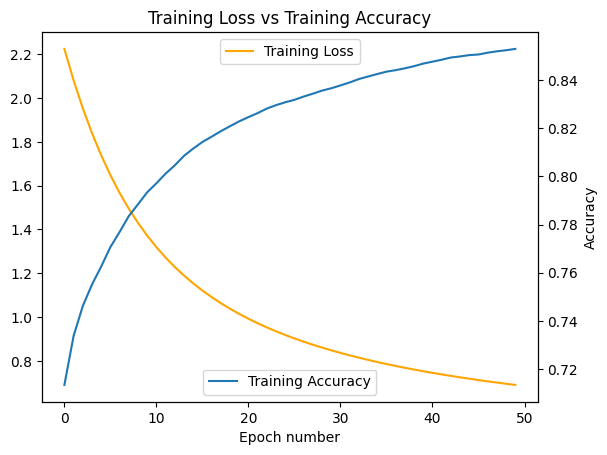

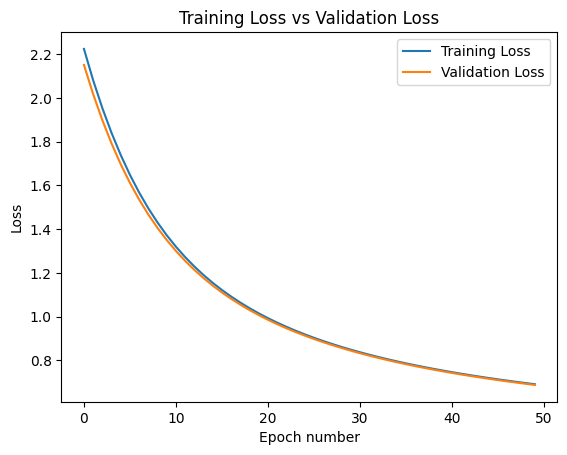

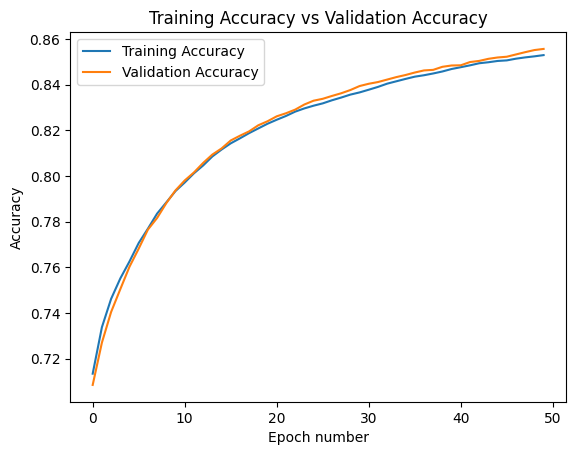

In [13]:

plot_loss_accuracy_data(train_loss_data, train_accuracy_data, 'Training Loss', 'Training Accuracy', 'Epoch number', 'Loss', 'Accuracy', )
plot_data(train_loss_data, validation_loss_data, "Training Loss", "Validation Loss", 'Epoch number', 'Loss', 'upper right')
plot_data(train_accuracy_data, validation_accuracy_data, "Training Accuracy", "Validation Accuracy", 'Epoch number', 'Accuracy', 'upper left')

### Find the accuracy on the validation set

In [14]:
# WRITE CODE HERE
print(f'Validation accuracy: {validation_accuracy_data[-1]  * 100:.2f}%')

Validation accuracy: 85.56%


In [15]:
# The next step is to find the optimal value for lambda, number of epochs, learning rate and batch size. 
# CHOSE ANY TWO from the above mentioned to tune.
# Create plot and table to show the effect of the hparams.

In [16]:
learning_rates = [1e-2, 1e-3, 1e-4]
regularization_coeff = [1e-3]
epoch_values = [50]
batch_sizes = [32, 64, 128]
result_data = []

for alpha in learning_rates:
    for lambda_value in regularization_coeff:
        for epochs in epoch_values:
            for batch_size in batch_sizes:
                model, _, _, _, validation_accuracy_data = train_slc_model(X_train, y_train, X_valid, y_valid, num_of_classes,
                                                                           alpha, lambda_value, epochs, batch_size, False)
                validation_accuracy = validation_accuracy_data[-1]
                result_data.append(
                    (alpha, batch_size, validation_accuracy))
                print(
                    f'''For Learning rate = {alpha:.2e}, Regularization Coefficient: {lambda_value:.2e} {epochs = } {batch_size = } we get,
                    Validation accuracy = {validation_accuracy_data[-1] * 100:.2f}%''')

For Learning rate = 1.00e-02, Regularization Coefficient: 1.00e-03 epochs = 50 batch_size = 32 we get,
                    Validation accuracy = 91.52%
For Learning rate = 1.00e-02, Regularization Coefficient: 1.00e-03 epochs = 50 batch_size = 64 we get,
                    Validation accuracy = 91.26%
For Learning rate = 1.00e-02, Regularization Coefficient: 1.00e-03 epochs = 50 batch_size = 128 we get,
                    Validation accuracy = 90.88%
For Learning rate = 1.00e-03, Regularization Coefficient: 1.00e-03 epochs = 50 batch_size = 32 we get,
                    Validation accuracy = 89.80%
For Learning rate = 1.00e-03, Regularization Coefficient: 1.00e-03 epochs = 50 batch_size = 64 we get,
                    Validation accuracy = 88.94%
For Learning rate = 1.00e-03, Regularization Coefficient: 1.00e-03 epochs = 50 batch_size = 128 we get,
                    Validation accuracy = 87.65%
For Learning rate = 1.00e-04, Regularization Coefficient: 1.00e-03 epochs = 50 batch_s

In [17]:
def print_results(data, table_column_names, display_plot=True):
    import pandas as pd
    import seaborn as sns
    df = pd.DataFrame(data, columns=table_column_names)
    # df[table_column_names[-1]] *= 100
    print(df)

    if display_plot:
        heatmap_data = df.pivot_table(
            values=table_column_names[2], index=table_column_names[0], columns=table_column_names[1])
        sns.heatmap(heatmap_data, annot=True)
        plt.xlabel(table_column_names[1])
        plt.ylabel(table_column_names[0])
        plt.title(
            f'Effect of {table_column_names[0]} and {table_column_names[1]} on {table_column_names[2]}')
        plt.show()

   Learning Rate  Batch Size  Validation Accuracy
0         0.0100          32             0.915167
1         0.0100          64             0.912583
2         0.0100         128             0.908750
3         0.0010          32             0.898000
4         0.0010          64             0.889417
5         0.0010         128             0.876500
6         0.0001          32             0.855667
7         0.0001          64             0.832667
8         0.0001         128             0.802750


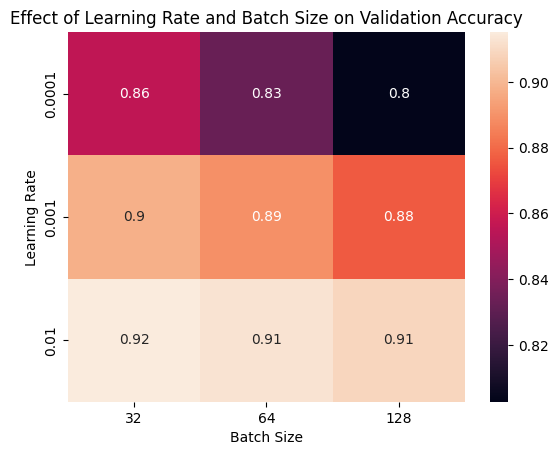

In [18]:
print_results(result_data, ['Learning Rate',
              'Batch Size', 'Validation Accuracy'])

Tuning All hyperparameters

In [19]:
learning_rates = [1e-1, 1e-2, 1e-3]
regularization_coeff = [1e-1, 1e-2, 1e-3]
epoch_values = [50, 100]
batch_sizes = [32, 64]
best_accuracy, best_index, current_index = -1, -1, 0
final_result_data = []

for alpha in learning_rates:
    for lambda_value in regularization_coeff:
        for epochs in epoch_values:
            for batch_size in batch_sizes:
                model, _, _, _, validation_accuracy_data = train_slc_model(X_train, y_train, X_valid, y_valid, num_of_classes,
                                                                           alpha, lambda_value, epochs, batch_size, False)
                validation_accuracy = validation_accuracy_data[-1]
                final_result_data.append(
                    (alpha, lambda_value, epochs, batch_size, validation_accuracy))
                if validation_accuracy > best_accuracy:
                    best_accuracy = validation_accuracy
                    best_index = current_index
                print(
                    f'''For Learning rate = {alpha:.2e}, Regularization Coefficient: {lambda_value:.2e} {epochs = } {batch_size = } we get,
                    Validation accuracy = {validation_accuracy_data[-1] * 100:.2f}%''')
                current_index += 1

For Learning rate = 1.00e-01, Regularization Coefficient: 1.00e-01 epochs = 50 batch_size = 32 we get,
                    Validation accuracy = 84.71%
For Learning rate = 1.00e-01, Regularization Coefficient: 1.00e-01 epochs = 50 batch_size = 64 we get,
                    Validation accuracy = 82.91%
For Learning rate = 1.00e-01, Regularization Coefficient: 1.00e-01 epochs = 100 batch_size = 32 we get,
                    Validation accuracy = 83.91%
For Learning rate = 1.00e-01, Regularization Coefficient: 1.00e-01 epochs = 100 batch_size = 64 we get,
                    Validation accuracy = 83.25%
For Learning rate = 1.00e-01, Regularization Coefficient: 1.00e-02 epochs = 50 batch_size = 32 we get,
                    Validation accuracy = 88.76%
For Learning rate = 1.00e-01, Regularization Coefficient: 1.00e-02 epochs = 50 batch_size = 64 we get,
                    Validation accuracy = 88.83%
For Learning rate = 1.00e-01, Regularization Coefficient: 1.00e-02 epochs = 100 batch_

In [20]:
print_results(final_result_data, ['Learning Rate', 'Regularization Coefficient', 'Epoch Count', 'Batch Size', 'Validation Accuracy'], False)

    Learning Rate  Regularization Coefficient  Epoch Count  Batch Size  \
0           0.100                       0.100           50          32   
1           0.100                       0.100           50          64   
2           0.100                       0.100          100          32   
3           0.100                       0.100          100          64   
4           0.100                       0.010           50          32   
5           0.100                       0.010           50          64   
6           0.100                       0.010          100          32   
7           0.100                       0.010          100          64   
8           0.100                       0.001           50          32   
9           0.100                       0.001           50          64   
10          0.100                       0.001          100          32   
11          0.100                       0.001          100          64   
12          0.010                     

### Report final performance on MNIST test set

In [21]:
# WRITE CODE HERE
assert best_index != -1
alpha, lambda_value, epochs, batch_size, _ = final_result_data[best_index]
print(f'Best parameters are, Learning Rate = {alpha:.2e}, Regularization Coefficient = {lambda_value:.2e}, {epochs = } {batch_size = }')
best_model, _, train_accuracy_data, _, validation_accuracy_data = train_slc_model(X_train, y_train, X_valid, y_valid, num_of_classes, alpha, lambda_value, epochs, batch_size, False)

y_test_pred = np.argmax(best_model.forward(X_test), axis=1)
test_accuracy = get_accuracy(y_test_pred, y_test)

print(f'Train Accuracy for model with best hyperparameters is {train_accuracy_data[-1] * 100:.2f}%')
print(f'Validation Accuracy for model with best hyperparameters is {validation_accuracy_data[-1] * 100:.2f}%')
print(f'Test Accuracy for model with best hyperparameters is {test_accuracy * 100:.2f}%')


Best parameters are, Learning Rate = 1.00e-02, Regularization Coefficient = 1.00e-03, epochs = 100 batch_size = 64
Train Accuracy for model with best hyperparameters is 91.73%
Validation Accuracy for model with best hyperparameters is 91.47%
Test Accuracy for model with best hyperparameters is 91.81%


### Find the best performing class and the worst performing class

In [22]:
from sklearn.metrics import confusion_matrix

matrix_data = confusion_matrix(y_test, y_test_pred)
per_class_accuracy = matrix_data.diagonal() / matrix_data.sum(axis=1)
best_class_value, worst_class_value = np.argmax(per_class_accuracy), np.argmin(per_class_accuracy)

print(f'Best performing class is class-{best_class_value} with an test accuracy of {per_class_accuracy[best_class_value] * 100:.2f}%')
print(f'Worst performing class is class-{worst_class_value} with an test accuracy of {per_class_accuracy[worst_class_value] * 100:.2f}%')

Best performing class is class-0 with an test accuracy of 97.86%
Worst performing class is class-5 with an test accuracy of 86.66%


# Training a Linear Classifier on MNIST from scikit-learn

In this section you have to train a linear classifier from the scikit-learn library and compare its results against your implementation.
(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(
    random_state=41, multi_class='multinomial', n_jobs=-1).fit(X_train, y_train)

train_predicitions = clf.predict(X_train)
test_predicitions = clf.predict(X_test)

train_accuracy_sklearn = accuracy_score(y_train, train_predicitions)
test_accuracy_sklearn = accuracy_score(y_test, test_predicitions)

/mnt/data/home/tejaa/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Compare the training and test accuracies for the your implementation and linear classifier from scikit-learn

In [24]:
# WRITE CODE HERE
print(f'Results from implemented model')
print(f'Train Accuracy = {train_accuracy_data[-1] * 100:.2f}%')
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

print(f'Results from scikit-learn trained model')
print(f'Train Accuracy = {train_accuracy_sklearn * 100:.2f}%')
print(f'Test Accuracy = {test_accuracy_sklearn * 100:.2f}%')

Results from implemented model
Train Accuracy = 91.73%
Test Accuracy = 91.81%
Results from scikit-learn trained model
Train Accuracy = 93.65%
Test Accuracy = 92.57%


### Any additional observations / comments?

In report

## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

Plots using 0.1% training data


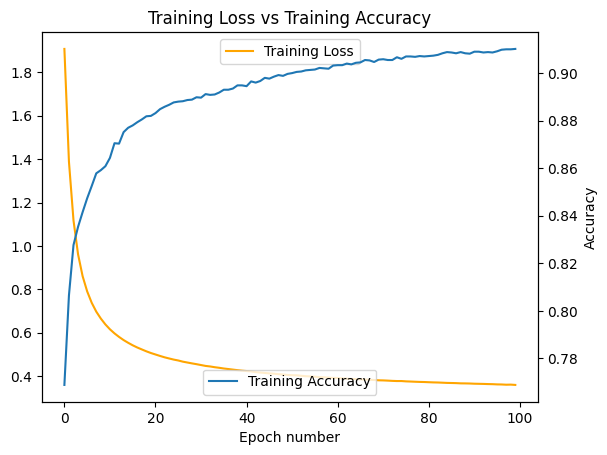

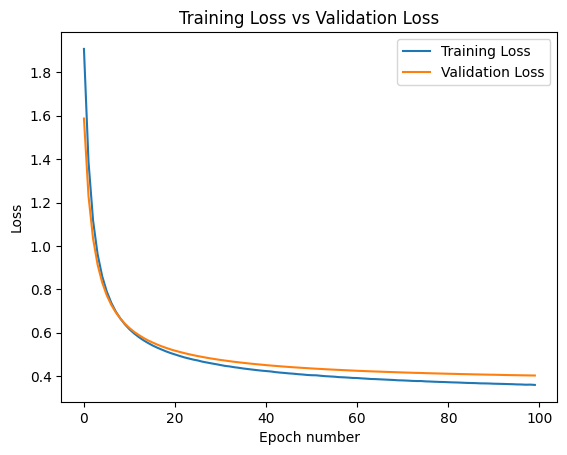

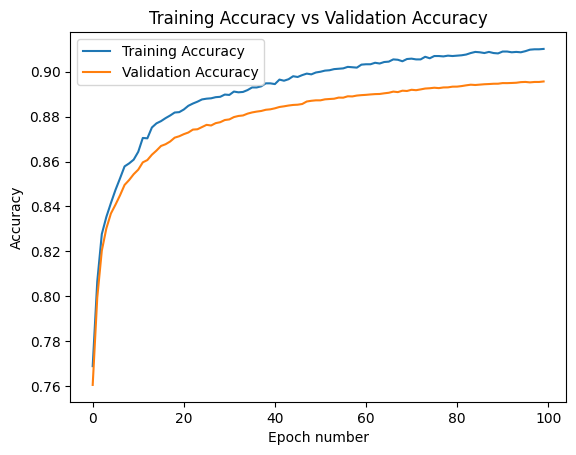

Plots using 0.2% training data


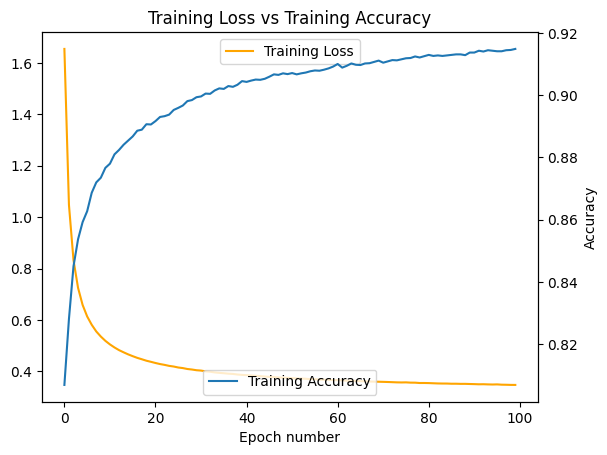

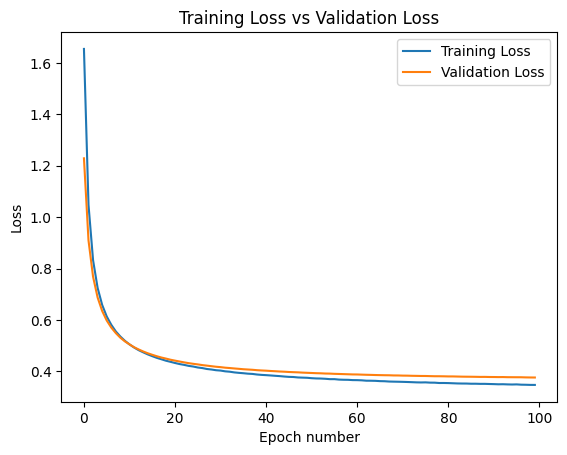

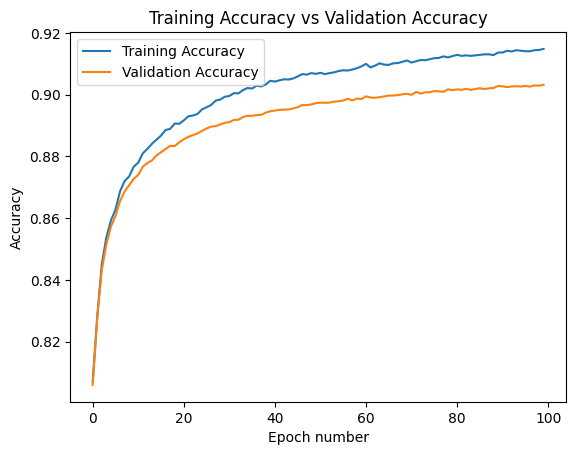

Plots using 0.5% training data


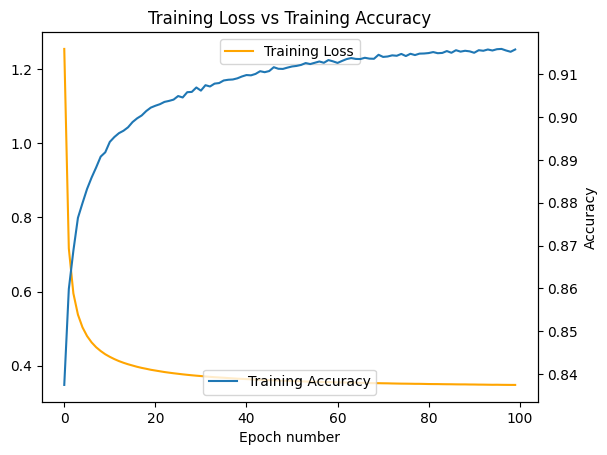

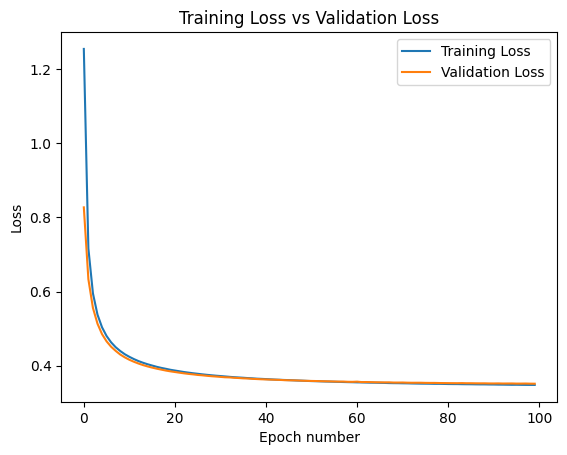

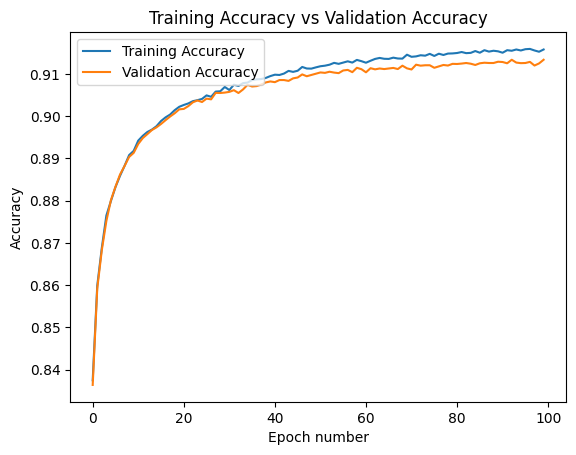

In [25]:
assert best_index != -1
alpha, lambda_value, epochs, batch_size, _ = final_result_data[best_index]

result_data = {}
for train_percent in [0.1, 0.2, 0.5]:

    X_train, y_train = load_mnist_data('./data', 'train')
    X_test, y_test = load_mnist_data('./data', 'test')

    X_train = X_train / 255
    X_test = X_test / 255

    num_of_classes = len(set(y_train))
    X_train, y_train, X_valid, y_valid = split_data(
        X_train, y_train, 1 - train_percent)

    model, train_loss_data, train_accuracy_data, validation_loss_data, validation_accuracy_data = train_slc_model(
        X_train, y_train, X_valid, y_valid, num_of_classes, alpha, lambda_value, epochs, batch_size, False)

    y_test_pred = np.argmax(model.forward(X_test), axis=1)
    test_accuracy = get_accuracy(y_test_pred, y_test)
    result_data[train_percent] = test_accuracy  

    print(f'Plots using {train_percent}% training data')

    plot_loss_accuracy_data(train_loss_data, train_accuracy_data, 'Training Loss', 'Training Accuracy', 'Epoch number', 'Loss', 'Accuracy')
    plot_data(train_loss_data, validation_loss_data, "Training Loss", "Validation Loss", 'Epoch number', 'Loss', 'upper right')
    plot_data(train_accuracy_data, validation_accuracy_data, "Training Accuracy", "Validation Accuracy", 'Epoch number', 'Accuracy', 'upper left')    

In [26]:
def plot_single_data(data1, data2, xlabel, ylabel, title):
    plt.plot(data1, data2, label=ylabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

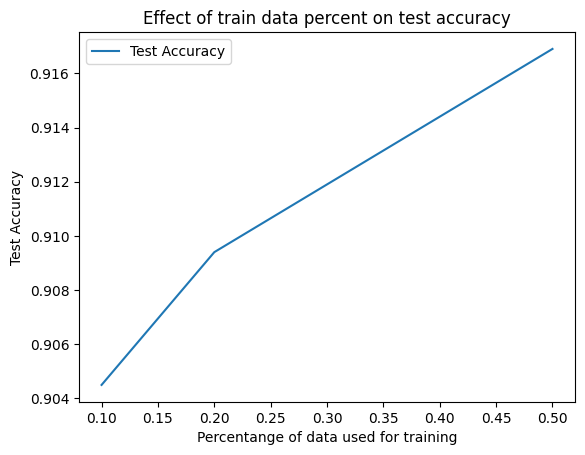

In [27]:

plot_single_data(result_data.keys(), result_data.values(), 'Percentange of data used for training', 'Test Accuracy', 'Effect of train data percent on test accuracy')

# Implementing Backpropagation

Now that you have had some experience with single layer networks, we can proceed to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simply put, a way of computing gradients of expressions through repeated application of chain rule. If
$$
L = f (g (h (\textbf{x})))
$$
then, by the chain rule we have:
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial \textbf{x}} 
$$

** Look into the class Lecture for more detail **



# Question 2 : Scalar Backpropagation

Evaluate the gradient of the following function w.r.t. the input:

$$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times x)+sin(\pi \times y/2)}{tanh(z^2)}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following inputs:
  * $(x,y,z)$ =  (2,4,1)
  * $(x,y,z)$ =  (9,14,3)
  * $(x,y,z)$ =  (128,42,666)
  * $(x,y,z)$ =  (52,14,28)

      

In [28]:
# To solve this problem, construct the computational graph
# Write a class with forward and backward functions, for each node if you like
# For eg:

# CAUTION: Carefully treat the input and output dimension variation. At worst, handle them with if statements.

class log():
    def __init__(self, x):
        self.result = None
        self.x = x

    def forward(self):
        self.result = np.log(self.x)
        return self.result

    def backward(self, back_grad):
        return back_grad/self.x


class tanh():
    def __init__(self, x):
        self.result = None
        self.x = x

    def forward(self):
        self.result = np.tanh(self.x)
        return self.result

    def backward(self, back_grad):
        return (1 - self.result ** 2) * back_grad


class add():
    def __init__(self, x, y):
        self.result = None
        self.x = x
        self.y = y

    def forward(self):
        self.result = self.x + self.y
        return self.result

    def backward(self, back_grad):
        return back_grad, back_grad


class div():
    def __init__(self, x, y):
        self.result = None
        self.x = x
        self.y = y

    def forward(self):
        self.result = self.x / self.y
        return self.result

    def backward(self, back_grad):
        der_x = back_grad / self.y
        der_y = -(back_grad * self.x) / (self.y ** 2)
        return der_x, der_y


class sqaure():
    def __init__(self, x):
        self.result = None
        self.x = x

    def forward(self):
        self.result = self.x ** 2
        return self.result

    def backward(self, back_grad):
        return back_grad * 2 * self.x


class sin():
    def __init__(self, x):
        self.result = None
        self.x = x

    def forward(self):
        self.result = np.sin(self.x)
        return self.result

    def backward(self, back_grad):
        return np.cos(self.x) * back_grad


class cos():
    def __init__(self, x):
        self.result = None
        self.x = x

    def forward(self):
        self.result = np.cos(self.x)
        return self.result

    def backward(self, back_grad):
        return -np.sin(self.x) * back_grad


class Sigmoid():

    def __init__(self, x):
        self.result = None
        self.x = x

    def forward(self):
        self.result = 1/(1 + np.exp(-self.x))
        return self.result

    def backward(self, back_grad):
        return back_grad * self.result * (1 - self.result)

In [29]:
# Now write the class func
# which constructs the graph (all operators), forward and backward functions.

class Func():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

        self.forward_value = None
        self.backward_value = None

    def forward(self):

        # Using the graph element's forward functions, get the output.

        self.sin = sin(np.pi * self.y/2)
        self.cos = cos(np.pi * self.x)
        self.square = sqaure(self.z)
        self.tanh = tanh(self.square.forward())
        self.add = add(self.sin.forward(), self.cos.forward())
        self.div = div(self.add.forward(), self.tanh.forward())
        self.sigmoid = Sigmoid(self.div.forward())
        self.log = log(self.sigmoid.forward())
        self.forward_value = self.log.forward()

        return self.forward_value

    def backward(self):
        # Use the saved outputs of each module, and backward() function calls
        self.backward_value = self.log.backward(1)
        self.backward_value = self.sigmoid.backward(self.backward_value)
        
        grad_num, grad_denom = self.div.backward(self.backward_value)
        grad_sin, grad_cos = self.add.backward(grad_num)
        grad_denom = self.tanh.backward(grad_denom)

        grad_x = self.cos.backward(grad_cos * np.pi)
        grad_y = self.sin.backward(grad_sin * np.pi / 2)
        grad_z = self.square.backward(grad_denom)

        return [grad_x, grad_y, grad_z]

In [30]:
inputs = [(2, 4, 1), (9, 14, 3), (128, 42, 666), (52, 14, 28)]
for input_data in inputs:
    x, y, z = input_data
    func = Func(x, y, z)
    forward_output = func.forward()
    gradients_backward_pass = func.backward()
    print(
        f'Inputs :- {x = }, {y = }, {z = }\n{forward_output = }\n{gradients_backward_pass = }\n')

Inputs :- x = 2, y = 4, z = 1
forward_output = -0.23823101469115085
gradients_backward_pass = [2.1417102890343505e-16, 0.43720979194276516, -0.3069722756588883]

Inputs :- x = 9, y = 14, z = 3
forward_output = -1.3132617097862371
gradients_backward_pass = [-2.5313688314302287e-15, -1.148344174369598, 2.672161875217988e-07]

Inputs :- x = 128, y = 42, z = 666
forward_output = -0.3132616875182231
gradients_backward_pass = [1.3244281103803985e-14, -0.42245219681098717, -0.0]

Inputs :- x = 52, y = 14, z = 28
forward_output = -0.31326168751822264
gradients_backward_pass = [-6.626324387577346e-15, -0.4224521968109866, -0.0]



## Question 3 : Modular Vector Backpropagation

* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set, MNIST, with the same train-val split.

In [31]:
# Class for Linear Layer (If you're stuck, you can refer to code of PyTorch/Tensorflow packages)
class LinearLayer:
    def __init__(self, input_size, output_size, bias=True):
        self.weights = np.random.normal(0, 1e-3, (input_size, output_size))
        if bias:
            self.bias = np.zeros((1, output_size))
        else:
            self.bias = None
            
    def forward(self, input_x):
        self.input_x = input_x
        output = np.matmul(input_x, self.weights)
        if self.bias is not None:
            output += self.bias
        return output

    def backward(self, grad_for_loss):
        self.grad_matrix = np.dot(self.input_x.T, grad_for_loss)
        self.grad_bias = np.sum(grad_for_loss, axis=0)
        return np.dot(grad_for_loss, self.weights.T)

In [32]:
# Class for ReLU
class ReLU:
    def __init__(self) -> None:
        self.x = None

    def forward(self, x):
        self.x = x
        return x * (x > 0)

    def backward(self, grad_for_loss):
        return grad_for_loss * (self.x > 0)

In [33]:
# Your 2 layer MLP
class MLP:
    def __init__(self, input_size, hidden_channels, output_size):
        self.layer_data = []

        self.layer1 = LinearLayer(input_size, hidden_channels)
        self.relu1 = ReLU()
        self.layer2 = LinearLayer(hidden_channels, output_size)

    def forward(self, input_x):
        scores = input_x
        scores = self.layer1.forward(scores)
        scores = self.relu1.forward(scores)
        scores = self.layer2.forward(scores)
        return scores

    def backward(self, grad_for_loss):
        grad_for_loss = self.layer2.backward(grad_for_loss)
        grad_for_loss = self.relu1.backward(grad_for_loss)
        grad_for_loss = self.layer1.backward(grad_for_loss)
        return grad_for_loss

In [34]:
# Train the MLP
def train_mlp_model(X_train, y_train, X_valid, y_valid, num_of_classes, alpha=1e-4, lambda_value=1e-3, epochs=50, batch_size=32, print_epoch_data=True, min_epocs_train=250, early_stopping_diff=1e-7):

    mlp_model = MLP(X_train.shape[1], 256, num_of_classes)
    early_stop_chance = 3
    train_loss_data, train_accuracy_data, validation_loss_data, validation_accuracy_data = [], [], [], []

    # Train for t epochs:
    for epoch in range(epochs):

        # Train on the train-set obtained from train-validation split
        # Use the mini-batch generator to get each mini-batch
        minibatch = get_minibatch(X_train, y_train, batch_size)
        batch_loss_data = []

        # Write code here for each iteration of training
        for iter_num, (input_x, input_y) in enumerate(minibatch):

            # Forward pass
            scores = mlp_model.forward(input_x)
            loss_value, grad_from_loss = loss_function(
                input_y, scores, lambda_value, [mlp_model.layer1.weights, mlp_model.layer2.weights])
            batch_loss_data.append(loss_value)

            # Backward pass
            mlp_model.backward(grad_from_loss)
            # Update weights
            mlp_model.layer1.weights = mlp_model.layer1.weights - \
                alpha * mlp_model.layer1.grad_matrix
            mlp_model.layer1.bias = mlp_model.layer1.bias - \
                alpha * mlp_model.layer1.grad_bias
            mlp_model.layer2.weights = mlp_model.layer2.weights - \
                alpha * mlp_model.layer2.grad_matrix
            mlp_model.layer2.bias = mlp_model.layer2.bias - \
                alpha * mlp_model.layer2.grad_bias

        # Log the training loss value and training accuracy
        train_loss = np.mean(batch_loss_data)
        y_train_pred = np.argmax(mlp_model.forward(X_train), axis=1)
        train_accuracy = get_accuracy(y_train_pred, y_train)
        train_accuracy_data.append(train_accuracy)
        train_loss_data.append(train_loss)

        validation_scores = mlp_model.forward(X_valid)
        validation_loss, _ = loss_function(
            y_valid, validation_scores, lambda_value, [mlp_model.layer1.weights, mlp_model.layer2.weights])

        y_valid_pred = np.argmax(validation_scores, axis=1)
        validation_accuracy = get_accuracy(y_valid_pred, y_valid)
        validation_accuracy_data.append(validation_accuracy)
        validation_loss_data.append(validation_loss)

        if print_epoch_data:
            print(
                f"{epoch = } {train_loss = } train_accuracy = {train_accuracy * 100:.2f}% {validation_loss = } validation_accuracy = {validation_accuracy * 100:.2f}%")

        if epoch > min_epocs_train:

            if validation_loss > validation_loss_data[-2]:
                if early_stop_chance:
                    early_stop_chance -= 1
                else:
                    print(
                        f'Earling stopping at {epoch = } because validation loss increased')
                    break
            if abs(validation_loss - validation_loss_data[-2]) <= early_stopping_diff:
                if early_stop_chance:
                    early_stop_chance -= 1
                else:
                    print(
                        f'Early stopping at {epoch = } because loss diff small')
                    break

        if epoch % 100 == 0:
            print(f'{epoch = }')

    return mlp_model, train_loss_data, train_accuracy_data, validation_loss_data, validation_accuracy_data

In [35]:
X_train, y_train = load_mnist_data('./data', 'train')
X_test, y_test = load_mnist_data('./data', 'test')

X_train = X_train / 255
X_test = X_test / 255

num_of_classes = len(set(y_train))
X_train, y_train, X_valid, y_valid = split_data(X_train, y_train)

alpha = 1e-3
epochs = 1000
batch_size = 32
lambda_value = 1e-3

model, train_loss_data, train_accuracy_data, validation_loss_data, validation_accuracy_data = train_mlp_model(X_train, y_train, X_valid, y_valid, num_of_classes,
                                                                                                              alpha, lambda_value, epochs, batch_size, True)

epoch = 0 train_loss = 2.3023257704465903 train_accuracy = 11.20% validation_loss = 2.301900430166282 validation_accuracy = 11.37%
epoch = 0
epoch = 1 train_loss = 2.301231569149019 train_accuracy = 11.20% validation_loss = 2.300276395213471 validation_accuracy = 11.37%
epoch = 2 train_loss = 2.298129777806793 train_accuracy = 17.48% validation_loss = 2.2948108926556205 validation_accuracy = 17.95%
epoch = 3 train_loss = 2.2865902164664873 train_accuracy = 29.40% validation_loss = 2.273697852595779 validation_accuracy = 29.65%
epoch = 4 train_loss = 2.2444120686690416 train_accuracy = 28.46% validation_loss = 2.20208432865313 validation_accuracy = 28.72%
epoch = 5 train_loss = 2.1291761899823376 train_accuracy = 37.27% validation_loss = 2.0361435815501037 validation_accuracy = 37.67%
epoch = 6 train_loss = 1.9016579618491245 train_accuracy = 53.46% validation_loss = 1.744604886298031 validation_accuracy = 53.47%
epoch = 7 train_loss = 1.5755353248438817 train_accuracy = 63.18% validati

### Plot the training loss and training accuracy plot

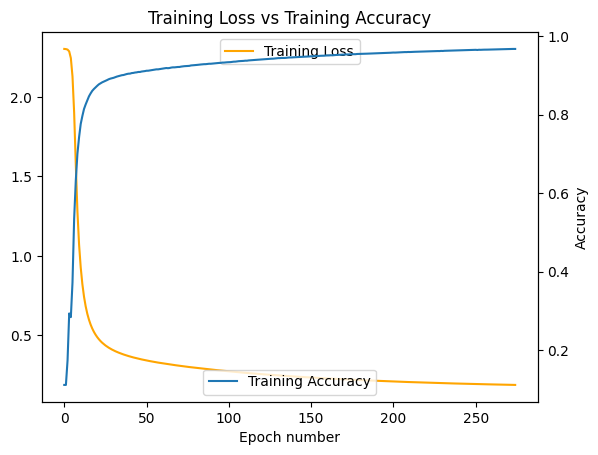

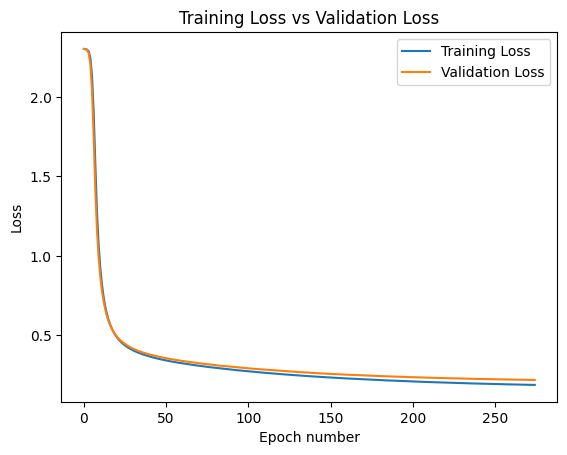

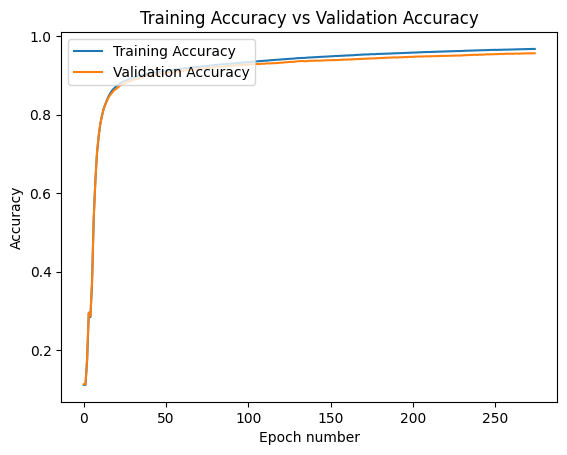

In [36]:
# Use the same utility functions defined in the previous question
# WRITE CODE HERE

plot_loss_accuracy_data(train_loss_data, train_accuracy_data, 'Training Loss', 'Training Accuracy', 'Epoch number', 'Loss', 'Accuracy', )
plot_data(train_loss_data, validation_loss_data, "Training Loss", "Validation Loss", 'Epoch number', 'Loss', 'upper right')
plot_data(train_accuracy_data, validation_accuracy_data, "Training Accuracy", "Validation Accuracy", 'Epoch number', 'Accuracy', 'upper left')

### Find the accuracy on the validation set

In [37]:
# WRITE CODE HERE
print(f'Validation accuracy: {validation_accuracy_data[-1]  * 100:.2f}%')

Validation accuracy: 95.61%


In [38]:
# Find the optimal value of learning rate and batch size.
# Use the same tuning strategy as the previous question
# Create plot and table to show the effect of the hparams.

X_train, y_train = load_mnist_data('./data', 'train')
X_test, y_test = load_mnist_data('./data', 'test')

X_train = X_train / 255
X_test = X_test / 255

num_of_classes = len(set(y_train))
X_train, y_train, X_valid, y_valid = split_data(X_train, y_train)
learning_rates = [1e-2, 1e-3]
regularization_coeff = [1e-3]
epoch_values = [1_000]
batch_sizes = [32, 64]
best_accuracy, best_index, current_index, best_mlp_model = -1, -1, 0, None
final_result_data = []

for alpha in learning_rates:
    for lambda_value in regularization_coeff:
        for epochs in epoch_values:
            for batch_size in batch_sizes:
                mlp_model_tune, _, _, _, validation_accuracy_data = train_mlp_model(X_train, y_train, X_valid, y_valid, num_of_classes,
                                                                           alpha, lambda_value, epochs, batch_size, False)
                validation_accuracy = validation_accuracy_data[-1]
                final_result_data.append(
                    (alpha, batch_size, validation_accuracy))
                if validation_accuracy > best_accuracy:
                    best_accuracy = validation_accuracy
                    best_index = current_index
                    best_mlp_model = mlp_model_tune
                print(
                    f'''For Learning rate = {alpha:.2e}, Regularization Coefficient: {lambda_value:.2e} {epochs = } {batch_size = } we get,
                    Validation accuracy = {validation_accuracy_data[-1] * 100:.2f}%''')
                current_index += 1

epoch = 0
epoch = 100
epoch = 200
Earling stopping at epoch = 254 because validation loss increased
For Learning rate = 1.00e-02, Regularization Coefficient: 1.00e-03 epochs = 1000 batch_size = 32 we get,
                    Validation accuracy = 97.57%
epoch = 0
epoch = 100
epoch = 200
Earling stopping at epoch = 254 because validation loss increased
For Learning rate = 1.00e-02, Regularization Coefficient: 1.00e-03 epochs = 1000 batch_size = 64 we get,
                    Validation accuracy = 97.48%
epoch = 0
epoch = 100
epoch = 200
Earling stopping at epoch = 278 because validation loss increased
For Learning rate = 1.00e-03, Regularization Coefficient: 1.00e-03 epochs = 1000 batch_size = 32 we get,
                    Validation accuracy = 95.61%
epoch = 0
epoch = 100
epoch = 200
epoch = 300
epoch = 400
Earling stopping at epoch = 497 because validation loss increased
For Learning rate = 1.00e-03, Regularization Coefficient: 1.00e-03 epochs = 1000 batch_size = 64 we get,
         

   Learning Rate  Batch Size  Validation Accuracy
0          0.010          32             0.975667
1          0.010          64             0.974833
2          0.001          32             0.956083
3          0.001          64             0.952833


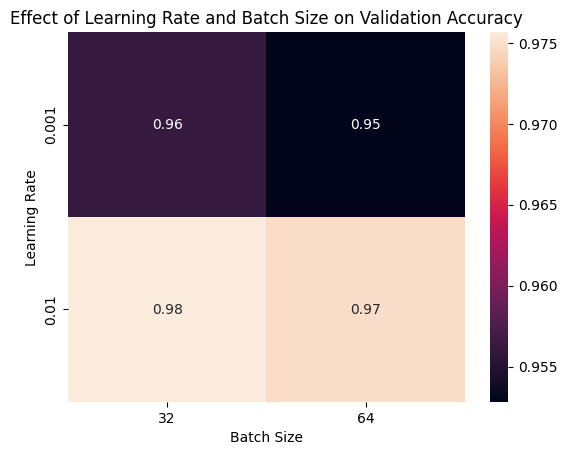

In [39]:
print_results(final_result_data, ['Learning Rate',
              'Batch Size', 'Validation Accuracy'])

### Report final performance on MNIST test set

In [40]:
# WRITE CODE HERE
assert best_index != -1
alpha, batch_size, _ = final_result_data[best_index]
lambda_value, epochs = 1e-3, 1_000

print(
    f'Best parameters are, Learning Rate = {alpha:.2e}, Regularization Coefficient = {lambda_value:.2e}, {epochs = } {batch_size = }')

y_train_pred = np.argmax(best_mlp_model.forward(X_train), axis=1)
train_accuracy = get_accuracy(y_train_pred, y_train)

y_valid_pred = np.argmax(best_mlp_model.forward(X_valid), axis=1)
validation_accuracy = get_accuracy(y_valid_pred, y_valid)

y_test_pred = np.argmax(best_mlp_model.forward(X_test), axis=1)
test_accuracy = get_accuracy(y_test_pred, y_test)

print(
    f'Train Accuracy for model with best hyperparameters is {train_accuracy * 100:.2f}%')
print(
    f'Validation Accuracy for model with best hyperparameters is {validation_accuracy * 100:.2f}%')
print(
    f'Test Accuracy for model with best hyperparameters is {test_accuracy * 100:.2f}%')

Best parameters are, Learning Rate = 1.00e-02, Regularization Coefficient = 1.00e-03, epochs = 1000 batch_size = 32
Train Accuracy for model with best hyperparameters is 99.99%
Validation Accuracy for model with best hyperparameters is 97.57%
Test Accuracy for model with best hyperparameters is 97.87%


### Find the best performing class and the worst performing class

In [41]:
# WRITE CODE HERE
from sklearn.metrics import confusion_matrix

matrix_data = confusion_matrix(y_test, y_test_pred)
per_class_accuracy = matrix_data.diagonal() / matrix_data.sum(axis=1)
best_class_value, worst_class_value = np.argmax(per_class_accuracy), np.argmin(per_class_accuracy)

print(f'Best performing class is class-{best_class_value} with an test accuracy of {per_class_accuracy[best_class_value] * 100:.2f}%')
print(f'Worst performing class is class-{worst_class_value} with an test accuracy of {per_class_accuracy[worst_class_value] * 100:.2f}%')

Best performing class is class-1 with an test accuracy of 98.94%
Worst performing class is class-9 with an test accuracy of 96.53%


### Any additional observations / comments?

In report

## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

epoch = 0
epoch = 100
epoch = 200
Earling stopping at epoch = 256 because validation loss increased
Plots using 0.1% training data


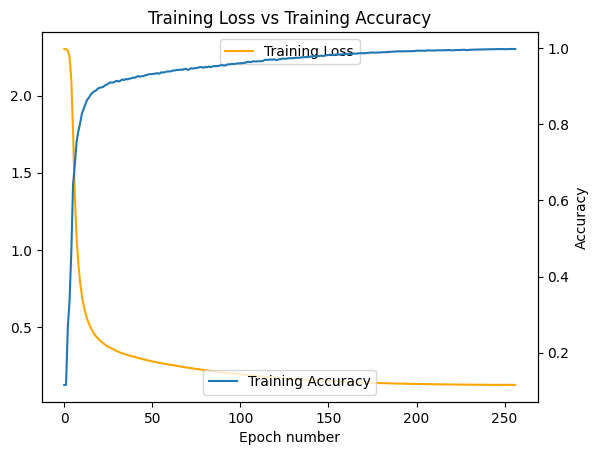

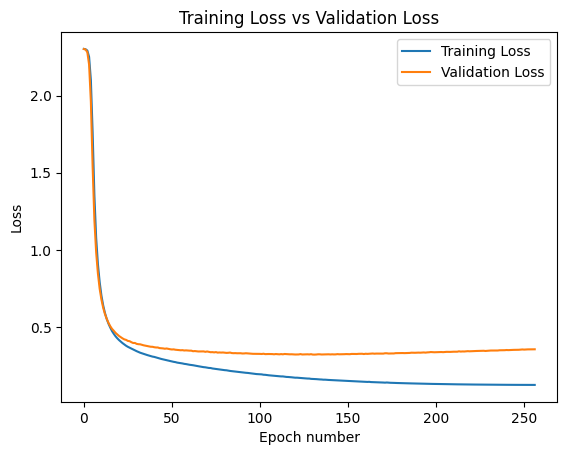

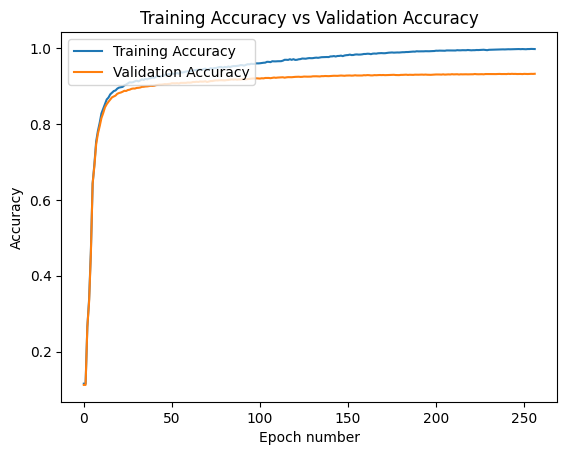

epoch = 0
epoch = 100
epoch = 200
Earling stopping at epoch = 254 because validation loss increased
Plots using 0.2% training data


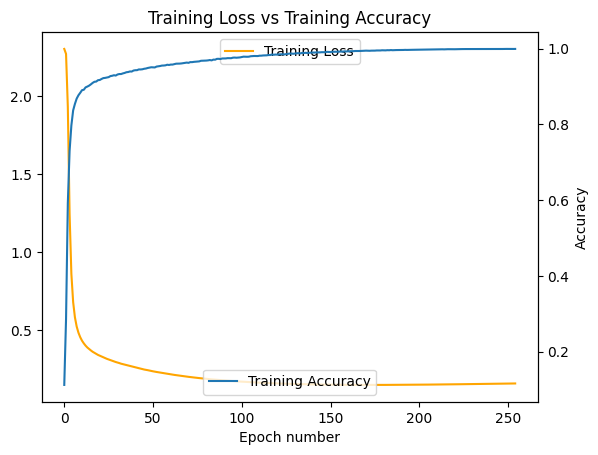

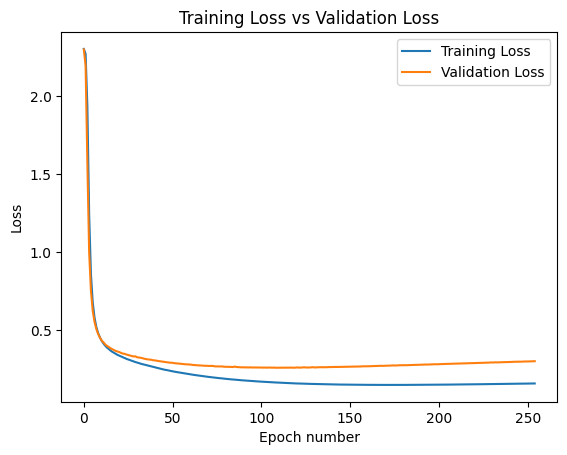

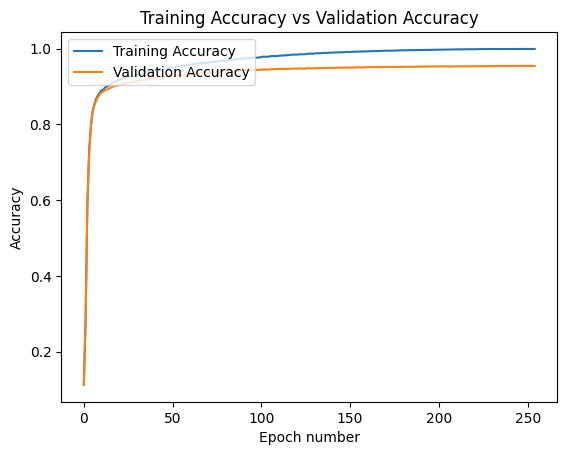

epoch = 0
epoch = 100
epoch = 200
Earling stopping at epoch = 255 because validation loss increased
Plots using 0.5% training data


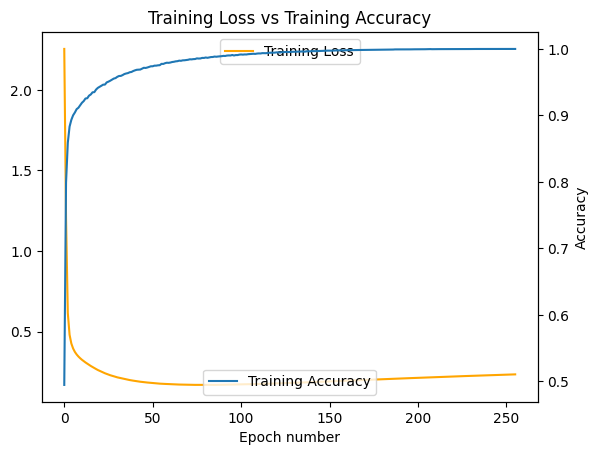

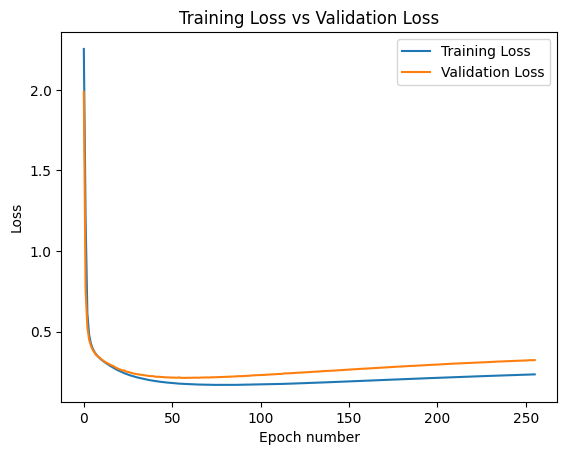

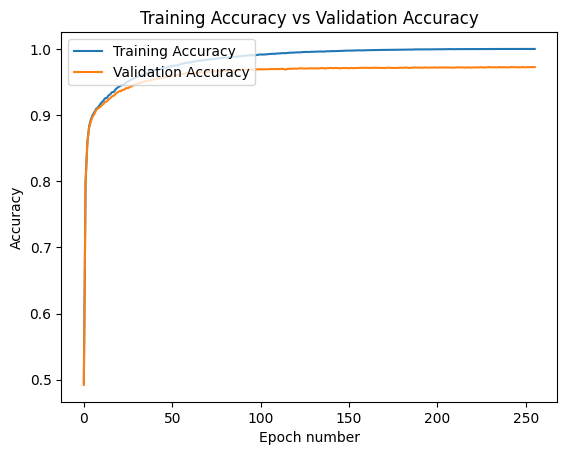

In [42]:
# WRITE CODE HERE
assert best_index != -1
alpha, batch_size, _ = final_result_data[best_index]
lambda_value, epochs = 1e-3, 1_000

result_data = {}
for train_percent in [0.1, 0.2, 0.5]:

    X_train, y_train = load_mnist_data('./data', 'train')
    X_test, y_test = load_mnist_data('./data', 'test')

    X_train = X_train / 255
    X_test = X_test / 255

    num_of_classes = len(set(y_train))
    X_train, y_train, X_valid, y_valid = split_data(
        X_train, y_train, 1 - train_percent)

    percent_mlp_model, train_loss_data, train_accuracy_data, validation_loss_data, validation_accuracy_data = train_mlp_model(
        X_train, y_train, X_valid, y_valid, num_of_classes, alpha, lambda_value, epochs, batch_size, False)

    y_test_pred = np.argmax(percent_mlp_model.forward(X_test), axis=1)
    test_accuracy = get_accuracy(y_test_pred, y_test)
    result_data[train_percent] = test_accuracy

    print(f'Plots using {train_percent}% training data')

    plot_loss_accuracy_data(train_loss_data, train_accuracy_data, 'Training Loss',
                            'Training Accuracy', 'Epoch number', 'Loss', 'Accuracy')
    plot_data(train_loss_data, validation_loss_data, "Training Loss",
              "Validation Loss", 'Epoch number', 'Loss', 'upper right')
    plot_data(train_accuracy_data, validation_accuracy_data, "Training Accuracy",
              "Validation Accuracy", 'Epoch number', 'Accuracy', 'upper left')

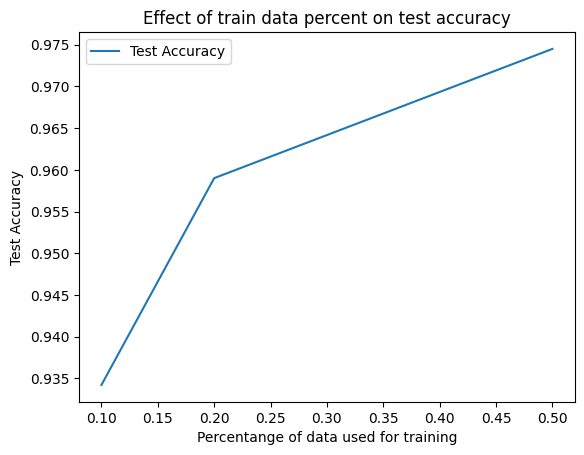

In [43]:
plot_single_data(result_data.keys(), result_data.values(), 'Percentange of data used for training', 'Test Accuracy', 'Effect of train data percent on test accuracy')


# Implementing a Convolution Module with Numpy

* This topic will require you to implement the Convolution operation using Numpy.
* We will use the Module for tasks like Blurring.
* Finally, we implement Backpropagation for the convolution module.


## Question 4

* Implement a naive Convolution module, with basic functionalities: kernel_size, padding, stride and dilation
  
* Test out the convolution layer by using it to do gaussian blurring on 10 random images of CIFAR-10 dataset


In [44]:
# Define a class Convolution Layer, which is initialized with the various required params:
class Convolution_Layer():

    def __init__(self, in_channels, out_channels, filter_size, bias=True, stride=1, padding=0, dilation=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        # For an untrained layer, set random initial filter weights
        self.weights = np.random.randn(
            self.out_channels, self.in_channels, self.filter_size[0], self.filter_size[1])

        if bias:
            self.bias = np.random.randn(self.out_channels)
        else:
            self.bias = None

    def forward(self, input_data):
        # Input Proprocess(According to pad etc.) Input will be of size (Batch_size, in_channels, inp_height, inp_width)
        batch_size, in_channels, inp_height, inp_width = input_data.shape
        # Reminder: Save Input for backward-prop
        self.input_data = input_data
        padded_input = np.pad(self.input_data, ((
            0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')

        out_height = int((inp_height + 2 * self.padding -
                         self.filter_size[0]) / self.stride + 1)
        out_width = int((inp_width + 2 * self.padding -
                        self.filter_size[1]) / self.stride + 1)

        output = np.zeros(
            (batch_size, self.out_channels, out_height, out_width))

        # Simple Conv operation:
        # Loop over every location in inp_height * inp_width for the whole batch
        for batch_index in range(batch_size):
            for chan_index in range(self.out_channels):
                height_i = 0
                for height_index in range(0, out_height, self.stride):
                    width_i = 0
                    for width_index in range(0, out_width, self.stride):
                        r_field_data = padded_input[batch_index, :, height_index:height_index +
                                                    self.filter_size[0], width_index:width_index + self.filter_size[1]]
                        output[batch_index, chan_index, height_i, width_i] = np.sum(
                            r_field_data * self.weights[chan_index, :, :, :])
                        if self.bias is not None:
                            output[batch_index, chan_index, height_index,
                                   width_index] += self.bias[chan_index]
                        width_i += 1
                    height_i += 1
        # Output will be of the size (Batch_size, out_channels, out_height, out_width)
        return output

    def backward(self, grad_of_output_size):

        # Naive Implementation
        # Speed is not a concern
        # Hint: gradients from each independant operation can be summed

        batch_size, out_channels, out_height, out_width = grad_of_output_size.shape
        padded_input = np.pad(self.input_data, ((
            0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')

        grad_weights = np.zeros_like(self.weights)

        if self.bias is not None:
            grad_bias = np.zeros_like(self.bias)
        else:
            grad_bias = None

        for batch_index in range(batch_size):
            for chan_index in range(self.out_channels):
                for height_index in range(0, out_height, self.stride):
                    for width_index in range(0, out_width, self.stride):
                        r_field_data = padded_input[batch_index, :, height_index:height_index +
                                                    self.filter_size[0], width_index:width_index + self.filter_size[1]]
                        grad_weights[chan_index, :, :, :] += r_field_data * \
                            grad_of_output_size[batch_index, chan_index, height_index,
                                                width_index]
                        if self.bias is not None:
                            grad_bias[chan_index] += grad_of_output_size[batch_index,
                                                                         chan_index, height_index, width_index]

        #  return gradient of the size of the weight kernel
        return grad_weights, grad_bias

    def set_weights(self, new_weights):
        # Replace the set of weights with the given 'new_weights'
        # use this for setting weights for blurring, bilateral filtering etc.
        self.weights = new_weights

### Download CIFAR-10 images and load it in a numpy array (https://www.cs.toronto.edu/~kriz/cifar.html)



In [45]:
# WRITE CODE HERE
import pickle


def load_cifr_data(path_to_images):
    with open(path_to_images, 'rb') as file:
        dict_data = pickle.load(file, encoding='bytes')
        return dict_data[b'data'].reshape(-1, 3, 32, 32), np.array(dict_data[b'labels'])

In [46]:

image_data, label_data = load_cifr_data('./cifar-10-batches-py/data_batch_1')

In [47]:
def get_gaussian_blur_kernel(size, sigma):
    kernel_data = np.zeros((size, size))
    for i in range(0, size):
        for j in range(0, size):
            kernel_data[i, j] = np.exp(-((i - size//2) **
                                       2 + (j - size//2) ** 2) / (2 * sigma ** 2))
    kernel_data = kernel_data/np.sum(kernel_data)
    return kernel_data

### Initialize a conv layer. Set weights for gaussian blurring (do not train the filter for this part). Visualise the filters using matplotlib


In [48]:
# RGB
in_channels = 3
# output 3 channels for final image.
out_channels = 5
# size of gaussian filter
filter_size = 5
conv = Convolution_Layer(
    in_channels, out_channels, (filter_size, filter_size))

gaussian_blur_kernel = get_gaussian_blur_kernel(filter_size, 0.8)
# expand the kernel for input and output channels.
actual_kernel = np.zeros((out_channels, in_channels, filter_size, filter_size))
for out_index in range(out_channels):
    for in_index in range(in_channels):
        actual_kernel[out_index, in_index, :] = gaussian_blur_kernel

conv.set_weights(actual_kernel)

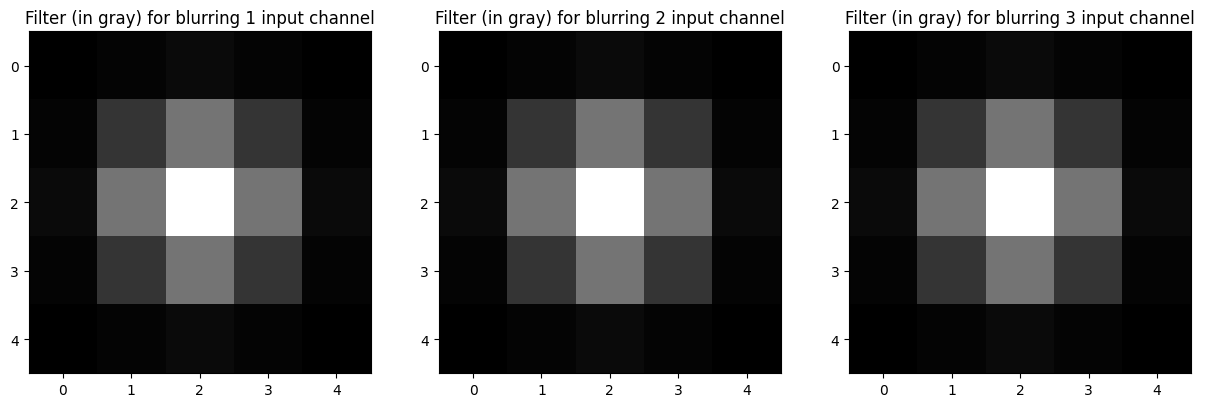

In [49]:
fig, axs = plt.subplots(1, in_channels, figsize=(15,15))

for i,ax in enumerate(axs.flat):
    axs[i].imshow(actual_kernel[0, i], cmap='gray')
    axs[i].set_title(f'Filter (in gray) for blurring {i + 1} input channel')
plt.show()

### Generate output for the first 5 images of the training set

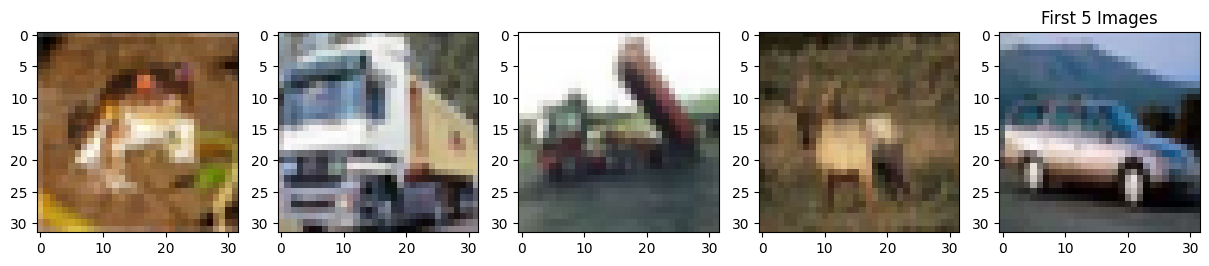

In [50]:
# WRITE CODE HERE
image_display_count = 5
first_5_image_data = image_data[:image_display_count]
fig, axs = plt.subplots(1, image_display_count, figsize=(15,15))

for i,ax in enumerate(axs.flat):
    img = first_5_image_data[i]
    axs[i].imshow(np.transpose(img,(1,2,0)))
plt.title('First 5 Images')
plt.show()

### Use matplotlib to show the input and corresponding blurred output

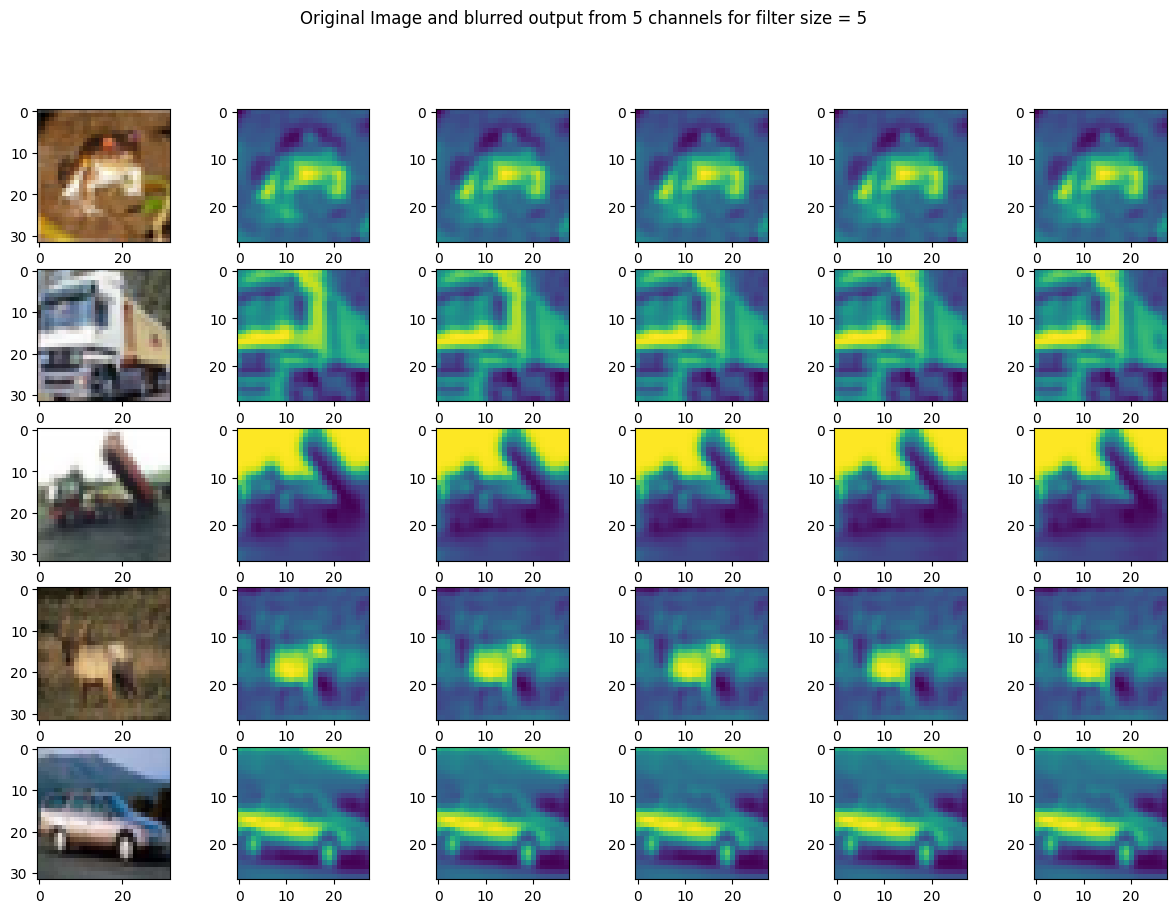

In [51]:
# WRITE CODE HERE
blur_images = conv.forward(first_5_image_data)
fig, axs = plt.subplots(image_display_count,
                        out_channels + 1, figsize=(15, 10))

for i, ax in enumerate(axs):
    img = first_5_image_data[i]
    ax[0].imshow(np.transpose(img, (1, 2, 0)))
    for out_channel_index in range(out_channels):
        ax[out_channel_index + 1].imshow(blur_images[i, out_channel_index])
        
plt.suptitle("Original Image and blurred output from 5 channels for filter size = 5")
plt.show()

## Question 5
<br>
Now we will use this module for training a simple Convolution Layer using CIFAR-10 images. 

* The goal is to learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Instantiate a Convolution  layer $C_0$ with 20 filters, each with size 5$\times$5 (RGB image, so 3 input channels). Load the given numpy array of size (20,3,5,5), which represents the weights of a convolution layer. Set the given values as the filter weights for $C_0$. Take 100 CIFAR-10 images. Save the output of these 100 images generated from this Convolution layer $C_0$. 
  
  * Now, initialize a new convolution layer $C$ with weight values sampled from uniform distribution [-1,1]. Use the $L_2$ loss between the output of this layer $C$ and the output generated in the previous step to learn the filter weights of $C_0$.


In [52]:
# Load filter weights from given numpy array "C0_weights.npy".
# Init a conv layer C_0 with these given weights

image_count_to_use = 100
in_channels = 3
out_channels = 20
filter_size = 5

image_data, label_data = load_cifr_data('./cifar-10-batches-py/data_batch_1')
first_x_image_data = image_data[:image_count_to_use] / 255
first_x_label_data = label_data[:image_count_to_use]

c0_layer = Convolution_Layer(
    in_channels, out_channels, (filter_size, filter_size))
c0_weights_data = np.load('C0_weights.npy')
c0_layer.set_weights(c0_weights_data)
final_c0_output_data = c0_layer.forward(first_x_image_data)

In [53]:
# for part 2 we need to write a class for the  L2 loss
class L2_loss():
    def ___init__(self):
        self.result = None

    def forward(self, C0_output, C_output):
        # Conv. output is of dimension (batchsize,channels,height,width)
        # calculate the L2 norm of (C0_output - C_output)
        self.result = C0_output - C_output
        loss = np.linalg.norm(self.result)
        return loss

    def backward(self, output_grad):
        # from the loss, and the conv. output, get the grad at each location
        # The grad is of the shape (batchsize,channels,height,width)
        grad = output_grad * 2 * -self.result
        return grad

batch_size = 8
	epoch = 0, Loss :- 969.3690958723512
	epoch = 1, Loss :- 403.67770844234167
	epoch = 2, Loss :- 335.54416606622476
	epoch = 3, Loss :- 304.3097272489244
	epoch = 4, Loss :- 282.13840058141426
	epoch = 5, Loss :- 269.57852478283417
	epoch = 6, Loss :- 250.81055313936514
	epoch = 7, Loss :- 239.31452527934513
	epoch = 8, Loss :- 231.3517517171501
	epoch = 9, Loss :- 220.64288515321854
	epoch = 10, Loss :- 215.43977832085872
	epoch = 11, Loss :- 214.2267982387266
	epoch = 12, Loss :- 208.8557588038427
	epoch = 13, Loss :- 207.36777013401948
	epoch = 14, Loss :- 203.5469463990152
	epoch = 15, Loss :- 199.166236827704
	epoch = 16, Loss :- 196.97951841653418
	epoch = 17, Loss :- 192.91336950006
	epoch = 18, Loss :- 189.61797335194422
	epoch = 19, Loss :- 186.1108213402872
	epoch = 20, Loss :- 184.4427302447525
	epoch = 21, Loss :- 180.79988824992827
	epoch = 22, Loss :- 181.13267558185117
	epoch = 23, Loss :- 180.307684705861
	epoch = 24, Loss :- 179.382807084668
	epoch = 25,

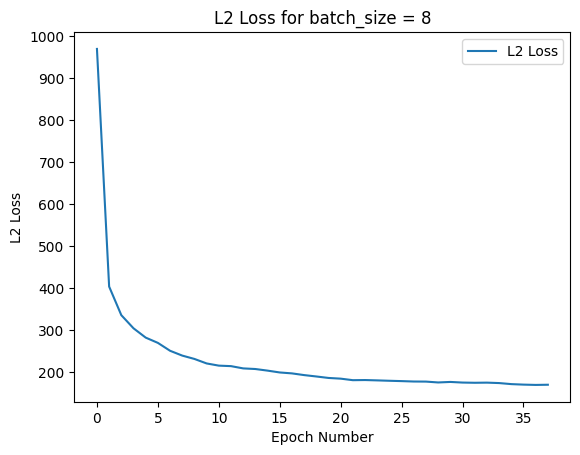

L2 distance = 617.4761607720582, when batch_size = 8
batch_size = 4
	epoch = 0, Loss :- 121.51730784470887
	epoch = 1, Loss :- 119.87966680538713
	epoch = 2, Loss :- 118.93363541988276
	epoch = 3, Loss :- 118.06798592520474
	epoch = 4, Loss :- 117.2944106299868
	epoch = 5, Loss :- 117.09922590555988
	epoch = 6, Loss :- 117.22276568491785
	epoch = 7, Loss :- 116.44563459238557
	epoch = 8, Loss :- 116.29278429425362
	epoch = 9, Loss :- 115.78990277220419
	epoch = 10, Loss :- 115.93241248135254
	epoch = 11, Loss :- 114.72427700792194
	epoch = 12, Loss :- 114.97632879062753
	epoch = 13, Loss :- 114.69617030333444
	epoch = 14, Loss :- 114.58050062910472
	epoch = 15, Loss :- 114.57342376770094
	epoch = 16, Loss :- 113.93821817569241
	epoch = 17, Loss :- 113.73008141923681
	epoch = 18, Loss :- 113.23235320201915
	epoch = 19, Loss :- 112.87585324901191
Earling stopping (20) because validation loss increased


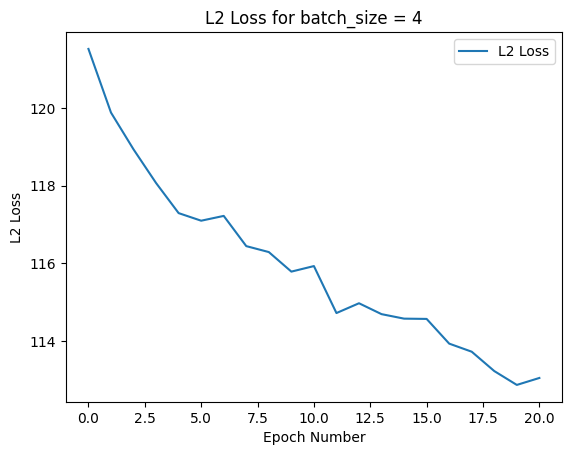

L2 distance = 561.2261602968755, when batch_size = 4
batch_size = 1
	epoch = 0, Loss :- 53.9615143378441
	epoch = 1, Loss :- 50.046710496976765
	epoch = 2, Loss :- 48.050038577626275
	epoch = 3, Loss :- 46.7546705699422
	epoch = 4, Loss :- 45.97568700929128
	epoch = 5, Loss :- 44.77029247300452
	epoch = 6, Loss :- 44.255743318354774
	epoch = 7, Loss :- 43.85425780288297
	epoch = 8, Loss :- 43.40823875307892
	epoch = 9, Loss :- 42.5665318687308
	epoch = 10, Loss :- 42.4956336762392
	epoch = 11, Loss :- 42.36100197050266
	epoch = 12, Loss :- 41.895561540886796
	epoch = 13, Loss :- 41.65672915752789
	epoch = 14, Loss :- 41.583505720550875
	epoch = 15, Loss :- 41.48561059298673
	epoch = 16, Loss :- 41.18478653645785
	epoch = 17, Loss :- 41.21709141492637
	epoch = 18, Loss :- 40.87897610739836
	epoch = 19, Loss :- 40.837027126564884
	epoch = 20, Loss :- 40.90758191664474
	epoch = 21, Loss :- 40.89206117771106
	epoch = 22, Loss :- 40.942038538278645
	epoch = 23, Loss :- 40.60011343901463
	ep

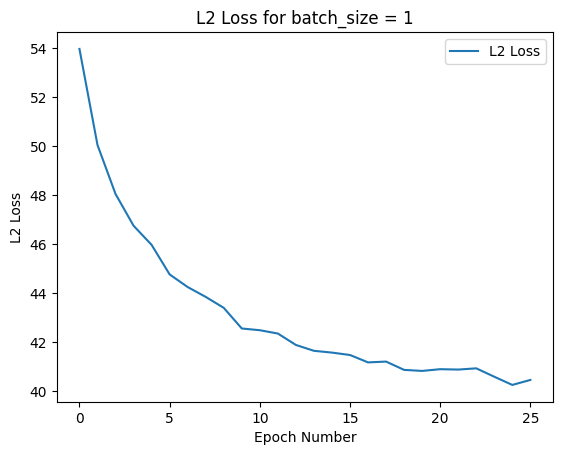

L2 distance = 429.59033361927476, when batch_size = 1


In [54]:
epochs = 50
alpha = 1e-2
batch_sizes = [8, 4, 1]
lambda_value = 1e-3
# Now Init a new conv layer C and a L2 loss layer
c_layer = Convolution_Layer(
    in_channels, out_channels, (filter_size, filter_size), True)
c_weights_data = np.random.uniform(-1, 1, size=(out_channels,
                                                in_channels, filter_size, filter_size))
c_layer.set_weights(c_weights_data)

l2 = L2_loss()
result_data = {}
# Train the new conv-layer C using the L2 loss to learn C_0, i.e., the set of given weights.
# Use mini-batches if required
for batch_size in batch_sizes:
    print(f'{batch_size = }')
    early_stop_chances = 3
    loss_data = []
    for epoch in range(epochs):
        batch_loss = []
        minibatch = get_minibatch(
            first_x_image_data, first_x_label_data, batch_size)
        for batch_index, (batch_image_data, _) in enumerate(minibatch):

            c_output_data = c_layer.forward(batch_image_data)
            c0_output_data = c0_layer.forward(batch_image_data)

            loss_value = l2.forward(c0_output_data, c_output_data)
            batch_loss.append(loss_value)

            output_grad = l2.backward(1)
            grad_weights, grad_bias = c_layer.backward(output_grad)
            grad_weights += 2 * lambda_value * c_layer.weights
            grad_weights = np.clip(grad_weights, -1.0, 1.0)
            c_layer.weights = c_layer.weights - alpha * grad_weights

            if grad_bias is not None:
                grad_bias = np.clip(grad_bias, -1.0, 1.0)
                c_layer.bias = c_layer.bias - alpha * grad_bias
        loss_value = np.mean(batch_loss)
        loss_data.append(loss_value)
        if epoch > 2:
            if loss_value > loss_data[-2]:
                if early_stop_chances:
                    early_stop_chances -= 1
                else:
                    print(
                        f'Earling stopping ({epoch}) because validation loss increased')
                    break
            if abs(loss_value - loss_data[-2]) <= 1e-7:
                if early_stop_chances:
                    early_stop_chances -= 1
                else:
                    print(f'Early stopping ({epoch}) because loss diff small')
                    break

        print(f'\t{epoch = }, Loss :- {loss_value}')

    plot_single_data(range(len(loss_data)), loss_data,
                     'Epoch Number', 'L2 Loss', f'L2 Loss for {batch_size = }')
    # Print L2 dist between output from the new trained convolution layer C and the outputs generated from C_0.
    final_c_output_data = c_layer.forward(first_x_image_data)
    final_l2_loss = l2.forward(final_c0_output_data, final_c_output_data)
    result_data[batch_size] = final_l2_loss
    print(f'L2 distance = {final_l2_loss}, when {batch_size = }')

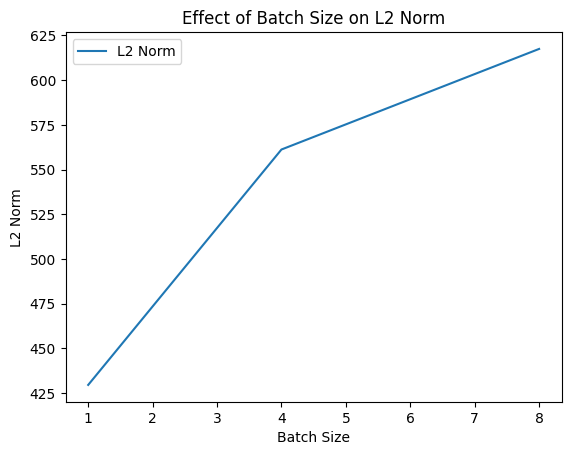

In [55]:
plot_single_data(result_data.keys(), result_data.values(), 'Batch Size', 'L2 Norm', 'Effect of Batch Size on L2 Norm')